In [6]:
## Try combining actor and critic into one model 
## conclusion: estimate bias killed it 

import random 
import numpy as np 
import gym
import torch
import torch.nn as nn
import torch.optim as optim 

class Object(object):
    pass

class ReplayBuffer(): 
    def __init__(self, capacity=10000): 
        self.n = 0 
        self.capacity = capacity 
        self.state_list = [] 
        self.action_list = [] 
        self.reward_list = [] 
        self.next_state_list = [] 
        self.done_list = [] 
        pass 
    def __len__(self):
         return self.n 
    def add(self, state, action, reward, next_state, done): 
        if self.n >= self.capacity: 
            ## discard earliest observation 
            self.state_list = self.state_list[1:] 
            self.action_list = self.action_list[1:] 
            self.reward_list = self.reward_list[1:] 
            self.next_state_list = self.next_state_list[1:] 
            self.done_list = self.done_list[1:] 
            self.n -= 1 
        pass 
        ## cast to torch  
        state = torch.tensor(state) 
        action = torch.tensor(action) 
        reward = torch.tensor(reward) 
        next_state = torch.tensor(next_state) 
        done = torch.tensor(done) 
        ## append to buffer 
        self.state_list.append(state) 
        self.action_list.append(action) 
        self.reward_list.append(reward) 
        self.next_state_list.append(next_state) 
        self.done_list.append(done) 
        self.n += 1 
        pass 
    def sample(self, batch_size=32): 
        ## sample lists 
        out = Object() ## transitions 
        out.state = [] 
        out.action = [] 
        out.reward = [] 
        out.next_state = [] 
        out.done = [] 
        for _ in range(batch_size): 
            idx = random.randint(0, self.n-1) 
            out.state.append(self.state_list[idx]) 
            out.action.append(self.action_list[idx]) 
            out.reward.append(self.reward_list[idx]) 
            out.next_state.append(self.next_state_list[idx]) 
            out.done.append(self.done_list[idx]) 
            pass 
        ## stack  
        out.state = torch.stack(out.state) 
        out.action = torch.stack(out.action) 
        out.reward = torch.stack(out.reward).reshape([-1,1]) 
        out.next_state = torch.stack(out.next_state) 
        out.done = torch.stack(out.done).reshape([-1,1]) 
        return out 
    pass 

# Define model 
class ActorCriticCombinedModel(nn.Module): 
    def __init__(self, state_dim, action_dim): 
        super(ActorCriticCombinedModel, self).__init__() 
        self.fc1 = nn.Linear(state_dim, 256) 
        self.fc2 = nn.Linear(256, 128) 
        self.fc_actor = nn.Linear(128, action_dim) 
        self.fc_critic = nn.Linear(128+action_dim, 1) 
        pass 
    def forward(self, state, action=None): 
        x = torch.relu(self.fc1(state)) 
        x = torch.relu(self.fc2(x)) 
        a = torch.tanh(self.fc_actor(x)) 
        c = None 
        if action is not None: 
            c = torch.cat([x, action], dim=1) 
            c = self.fc_critic(c) 
            pass 
        return a, c 
    pass 

# Create the actor and critic networks
model = ActorCriticCombinedModel(state_dim=4, action_dim=1)
target_model = ActorCriticCombinedModel(state_dim=4, action_dim=1)

# Define the optimizers 
optimizer = optim.Adam(model.parameters(), lr=1e-4) 

# Create the replay buffer 
replay_buffer = ReplayBuffer(capacity=100000) 

# Define the environment 
env = gym.make('CartPole-v1') 

reward_list = [] 
p_list = [] # DEBUG 
GAMMA = 0.99 

# Train the agent
for episode in range(1000):
    state = env.reset()
    target_model.load_state_dict(model.state_dict()) 

    for t in range(1000):
        action, _ = model(state=torch.tensor(state)) 
        if np.random.binomial(1, max(0,50-episode)/50) > 0: 
            ## random action 
            action = torch.tensor(np.random.uniform(low=-1., high=1.)).reshape([1]) 
            pass 
        
        action_p = action.item() * .5 + .5 
        action_int = np.random.binomial(1, action_p) ## must be 0 or 1 
        next_state, reward, done, _ = env.step(action_int) 

        replay_buffer.add(state, action, reward, next_state, done) 

        if len(replay_buffer) > 1000: 
            # Sample a batch of transitions from the replay buffer 
            transitions = replay_buffer.sample(batch_size=256) 

            # Calculate the target Q-values
            target_A, _ = target_model(transitions.next_state) 
            _, target_Q = target_model(transitions.next_state, target_A) 
            target_Q = (1 - transitions.done.int()) * target_Q.clone().detach() * GAMMA + transitions.reward 

            # Calculate the current Q-values
            current_A, current_Q = model(transitions.state, transitions.action) 

            # Calculate the critic loss
            critic_loss = torch.mean((target_Q - current_Q).pow(2)) 

            # Calculate actor loss 
            actor_loss, _ = target_model(transitions.state, current_A) 
            actor_loss = -torch.mean(actor_loss) 

            loss = actor_loss + critic_loss 

            # Update network 
            optimizer.zero_grad() 
            loss.backward() 
            optimizer.step() 
            pass 

        state = next_state

        if done:
            break

    # Evaluate the agent
    episode_reward = 0 
    state = env.reset() 

    for t in range(1000): 
        action, _ = model(torch.tensor(state))

        action_p = action.item() * .5 + .5 
        action_int = np.random.binomial(1, action_p) 
        next_state, reward, done, _ = env.step(action_int) 
        p_list.append(action.item()) # DEBUG 

        episode_reward += reward
        state = next_state 

        if done:
            break
    
    reward_list.append(episode_reward)
    print(f'Episode {episode}: {episode_reward}, len(replay_buffer): {len(replay_buffer)}')

/tmp/ipykernel_4481/2340304714.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  action = torch.tensor(action)


Episode 0: 9.0, len(replay_buffer): 20
Episode 1: 18.0, len(replay_buffer): 46
Episode 2: 11.0, len(replay_buffer): 60
Episode 3: 20.0, len(replay_buffer): 69
Episode 4: 10.0, len(replay_buffer): 83
Episode 5: 25.0, len(replay_buffer): 106
Episode 6: 38.0, len(replay_buffer): 115
Episode 7: 20.0, len(replay_buffer): 144
Episode 8: 21.0, len(replay_buffer): 159
Episode 9: 11.0, len(replay_buffer): 183
Episode 10: 12.0, len(replay_buffer): 228
Episode 11: 30.0, len(replay_buffer): 242
Episode 12: 30.0, len(replay_buffer): 271
Episode 13: 13.0, len(replay_buffer): 295
Episode 14: 20.0, len(replay_buffer): 337
Episode 15: 15.0, len(replay_buffer): 364
Episode 16: 16.0, len(replay_buffer): 377
Episode 17: 16.0, len(replay_buffer): 392
Episode 18: 24.0, len(replay_buffer): 433
Episode 19: 12.0, len(replay_buffer): 442
Episode 20: 32.0, len(replay_buffer): 459
Episode 21: 19.0, len(replay_buffer): 481
Episode 22: 20.0, len(replay_buffer): 501
Episode 23: 12.0, len(replay_buffer): 523
Episode 

KeyboardInterrupt: 

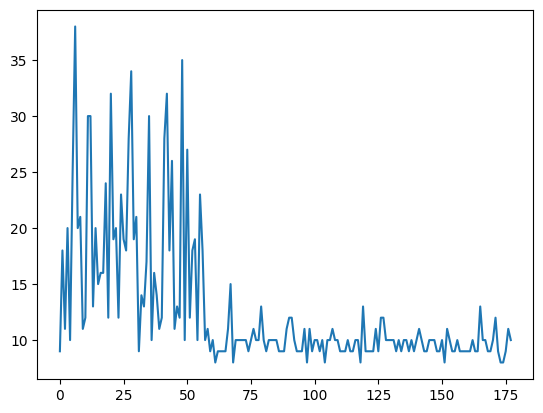

In [7]:
import matplotlib.pyplot as plt


plt.plot(reward_list)
plt.show()

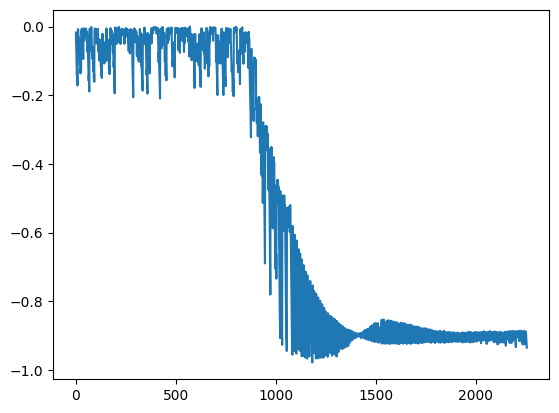

In [8]:
import matplotlib.pyplot as plt


plt.plot(p_list)
plt.show()